# M7 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Useful imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import plotly.graph_objects as go
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# Silent warnings
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = 'data'

/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 0: Research Question

**Research question:**
*How do student profiles vary across different time periods in terms of performance?*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Initial Preprocessing

We will begin by applying the same preprocessing steps used in M4 for `activity.csv` and `all_scores.csv`. For conciseness, we will not revisit or plot preprocessing steps that were already discussed in M4. Readers already familiar with M4 may skip directly to [Task 1, B](#task-1-b), where we introduce the new preprocessing steps specific to our M7 objectives.

In [2]:
def preprocess_user_activity():
    """
    Load and preprocess activity data as in M4

    Returns:
    --------
    user_activity : pd.DataFrame
        DataFrame containing user activity statistics as in M4
    """
    # Load the data
    activity = pd.read_csv(f'{DATA_DIR}/activity.csv')

    # Convert timestamps
    activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
    activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
    activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

    # Remove logically inconsistent rows
    activity = activity[activity['activity_completed'] > activity['activity_started']]

    # Compute duration in minutes
    activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
    activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

    # Remove long-duration activities (>24 hours)
    activity = activity[activity['activity_duration_minutes'] <= 24 * 60]

    # IQR-based outlier filtering
    Q1 = activity['activity_duration_minutes'].quantile(0.25)
    Q3 = activity['activity_duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    activity = activity[
        (activity['activity_duration_minutes'] >= lower_bound) &
        (activity['activity_duration_minutes'] <= upper_bound)
    ]

    # Daily activity extraction
    user_daily_activity = activity.copy(deep=True)
    user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
    user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
    user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
    user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
    user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days
    user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

    # Aggregate user-level stats
    user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
    user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
    user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values
    user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
        lambda x: (x['activity_completed'] - x['activity_started']).median()
    ).reset_index(drop=True)
    user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
    user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

    # Convert median duration to minutes and drop the timedelta column
    user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
    user_activity.drop(columns=['median_activity_duration'], inplace=True)

    return activity, user_daily_activity, user_activity

activity, user_daily_activity, user_activity = preprocess_user_activity()

display(user_activity.head())
print("Lenght of user_activity: ", len(user_activity))

,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Lenght of user_activity:  843


We now have the following preprocessed dataframes:

* `activity`: The cleaned activity dataframe, where each row represents a single user activity (a user may have multiple entries per day).
* `user_daily_activity`: The activity data aggregated by user and day.
* `user_activity`: The daily data further aggregated by user.


<a id="task-1-b"></a>
### B) Determining Time Periods

**Approach:**

We now aim to analyze student activity over time and observe how their profiles evolve. To achieve this, we will divide the timeline into non-overlapping periods. These periods could be defined by years (e.g., 2023, 2024, 2025), semesters, seasons, months, etc.

There are two key properties we want to maintain:

- **Period Length**: All periods should have the same duration.
- **Data Balance**: No period should contain significantly more or less students than the others.

To guide our choice of periods, we begin by visualizing the distribution of activity per student over time.


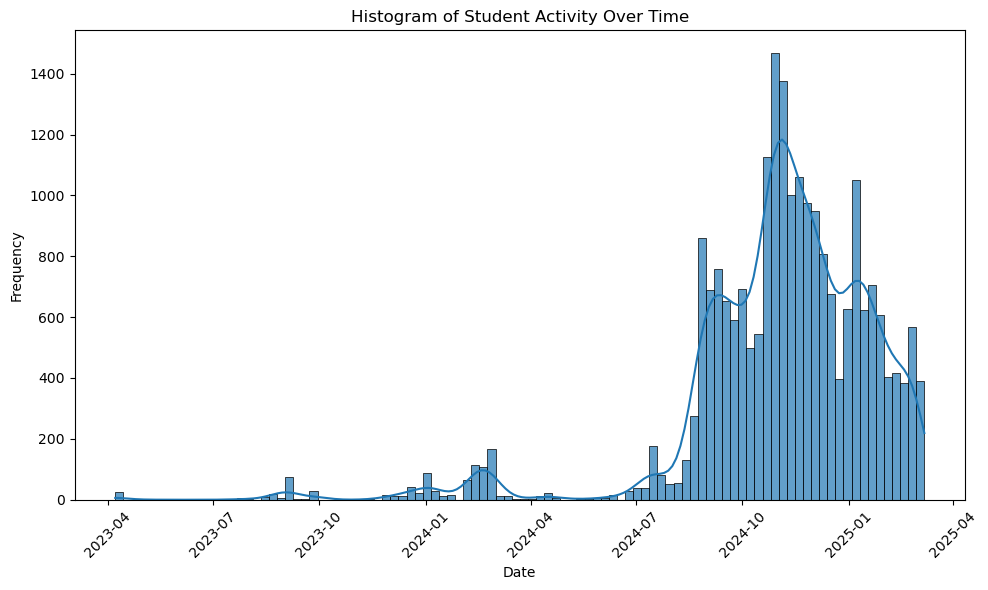

Number of unique users in 2023: 14
Number of unique users in 2024: 729
Number of unique users in 2025: 414


In [3]:
# Plot a histogram of activity start dates
plt.figure(figsize=(10, 6))
sns.histplot(activity['activity_started'], 
             bins=100, 
             alpha=0.7, 
             kde=True)

plt.title('Histogram of Student Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print number of unique users per year
min_year = activity['activity_started'].dt.year.min()
max_year = activity['activity_started'].dt.year.max()
for year in range(min_year, max_year + 1):
    print(f"Number of unique users in {year}:", activity[activity['activity_started'].dt.year == year]['user_id'].nunique())


**Observation:**

We observe that there were only 14 unique students in early 2023, compared to 729 in 2024, and 414 in 2025. Additionally, a few outliers appear in early 2023 that should be excluded from the analysis.

Interestingly, the right side of the distribution reveals a clear pattern with three noticeable peaks, indicating periods of significantly higher activity compared to the initial phase.

After testing various time segmentations, we ultimately selected the periods shown in the following figure.

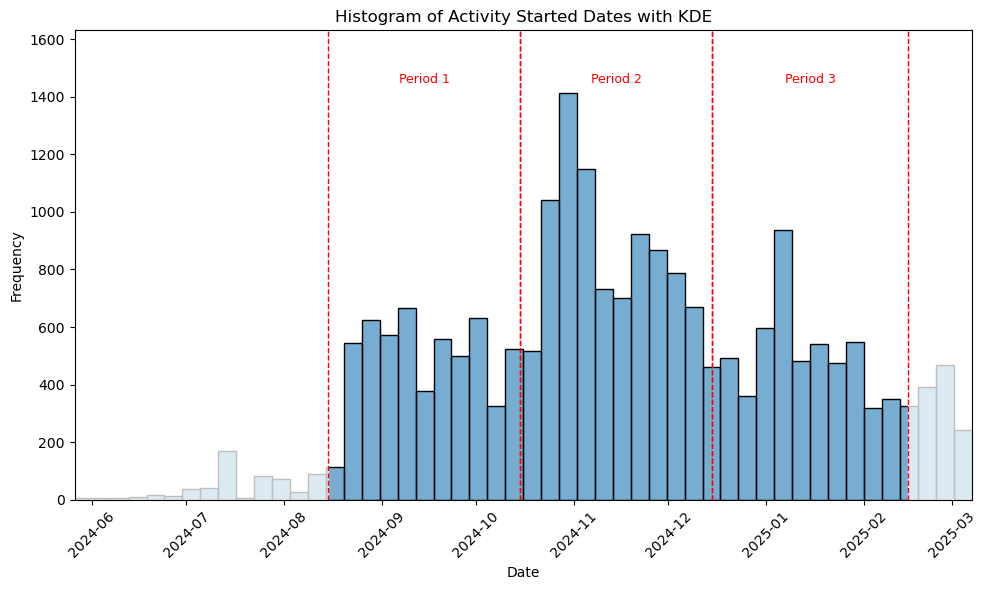

Number of unique users in Period 1: 427
Number of unique users in Period 2: 565
Number of unique users in Period 3: 417


In [4]:
# Remove outliers in activity_started with IQR method only for visualization
Q1 = activity['activity_started'].quantile(0.25)
Q3 = activity['activity_started'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
activity_viz = activity[
    (activity['activity_started'] >= lower_bound) &
    (activity['activity_started'] <= upper_bound)
]

# Define dynamic periods
periods = [
    ('2024-08-15', '2024-10-15', 'Period 1'),
    ('2024-10-15', '2024-12-15', 'Period 2'),
    ('2024-12-15', '2025-02-15', 'Period 3'),
]

# Prepare range
min_date = activity_viz['activity_started'].min()
max_date = activity_viz['activity_started'].max()

# Plot histogram and KDE using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    activity_viz['activity_started'],
    bins=50,
    alpha=0.6,
)

# Convert period boundaries to timestamps
period_bounds = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end, _ in periods]
first_start = period_bounds[0][0]
last_end = period_bounds[-1][1]

# Shade before first and after last period
shade_color, shade_alpha = 'white', 0.75
if min_date < first_start:
    plt.axvspan(min_date, first_start, color=shade_color, alpha=shade_alpha)
if max_date > last_end:
    plt.axvspan(last_end, max_date, color=shade_color, alpha=shade_alpha)

# Add vertical dashed lines and period labels
period_color = 'red'
ymax = plt.gca().get_ylim()[1]
for (start_ts, end_ts), (_, _, period_name) in zip(period_bounds, periods):
    midpoint = start_ts + (end_ts - start_ts) / 2
    plt.axvline(start_ts, color=period_color, linestyle='--', linewidth=1)
    plt.axvline(end_ts, color=period_color, linestyle='--', linewidth=1)
    plt.text(midpoint, ymax, period_name,
             ha='center', va='top', fontsize=9, color=period_color,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Final formatting
plt.title('Histogram of Activity Started Dates with KDE')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlim(min_date, max_date)
plt.ylim(0, ymax * 1.1)  # To give some space above the highest bar
plt.grid(False)
plt.tight_layout()
plt.show()

# Print the number of unique users in each period
for start, end, period_name in periods:
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    unique_users = activity[
        (activity['activity_started'] >= start_date) &
        (activity['activity_started'] <= end_date)
    ]['user_id'].nunique()
    print(f"Number of unique users in {period_name}:", unique_users)

**Approach:**

We deliberately chose not to place the period boundaries exactly at the local minima between peaks in the activity distribution, in order to preserve consistent period lengths.

The selected periods are as follows:

* **Period 1**: August 15, 2024 – October 15, 2024 (427 unique students)
* **Period 2**: October 15, 2024 – December 15, 2024 (565 unique students)
* **Period 3**: December 15, 2024 – February 15, 2025 (417 unique students)

While these periods do not align with conventional timeframes such as seasons or academic terms, they each span exactly two months and include a comparable number of unique students, allowing for meaningful analysis of changes over time.

We believe that defining periods should be a data-driven process tailored to the specific characteristics of the dataset, rather than relying on fixed calendar windows that may not yield relevant insights.

For conciseness, we will refer to these periods as *Period i* throughout the notebook, rather than repeatedly mentioning the corresponding dates.

### C) Student Activtiy by Time Period

We will now create the student dataframes for each time period. These will be similar to the one used in M4, but with the addition of a temporal dimension.

In [5]:
def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.
    """
    user_activity_periods = {}

    for start_date, end_date, period_name in periods:
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) &
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)

        if period_activity.empty:
            continue

        user_daily_activity = period_activity.copy()
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        duration_median = (period_activity['activity_completed'] - period_activity['activity_started']).groupby(period_activity['user_id']).median()

        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        user_activity['period'] = period_name

        user_activity_periods[period_name] = user_activity

    return user_activity_periods

In [6]:
# Create the period user activity dict
user_activity_periods = create_user_activity_by_period(activity, periods)

# Concatenate all into one dataframe
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nUser activity across all periods:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")


User activity across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,128,NaN,1,6,2,1.525000,Period 1
1,129,NaN,1,1,1,1.850000,Period 1
2,130,NaN,1,66,4,0.375000,Period 1
3,131,NaN,1,11,2,0.600000,Period 1
4,142,NaN,1,9,2,6.483333,Period 1


Shape: (1409, 7)


Let’s now visualize the number of students in each period and how their retention evolves over time.

In [7]:
def plot_student_retention_sankey():
    """
    Plot a Sankey diagram showing student retention over time.
    """
    # Count unique users in each period
    user_counts = {}
    for period_name, user_activity in user_activity_periods.items():
        unique_users = user_activity['user_id'].nunique()
        user_counts[period_name] = unique_users

    # Continous periods pairs
    period_pairs = []
    for i in range(len(periods) - 1):
        period1 = periods[i][2]
        period2 = periods[i + 1][2]
        period_pairs.append((period1, period2))

    # Count common users in each pair of continuous periods
    common_users = {}
    for period1, period2 in period_pairs:
        users_period1 = user_activity_periods[period1]['user_id'].unique()
        users_period2 = user_activity_periods[period2]['user_id'].unique()
        common_count = len(set(users_period1) & set(users_period2))
        common_users[(period1, period2)] = common_count

    period_names = [p for _, _, p in periods]
    num_periods = len(period_names)

    label_list, label_index = [], {}
    node_colors, node_x, node_y = [], [], []

    # Main period nodes
    for i, period in enumerate(period_names):
        label = f"{user_counts[period]} students"
        label_index[period] = len(label_list)
        label_list.append(label)
        node_colors.append("#4c72b0")
        node_x.append(i / (num_periods - 1))
        node_y.append(0.1)

    # Dropout nodes
    for i, period in enumerate(period_names[:-1]):
        nb_dropout = user_counts[period] - common_users[(period, period_names[i + 1])]
        label = f"{nb_dropout} dropped"
        label_index[f"{period}_dropout"] = len(label_list)
        label_list.append(label)
        node_colors.append("#d62728")
        node_x.append((i + 1) / (num_periods - 1))
        node_y.append(0.7)

    # Hidden new joiner nodes
    for i, period in enumerate(period_names[1:], start=1):
        label_index[f"{period}_new"] = len(label_list)
        label_list.append("")  # hidden label
        node_colors.append("rgba(0,0,0,0)")
        node_x.append(i / (num_periods - 1))
        node_y.append(1.0)

    # Link setup
    sources, targets, values = [], [], []
    link_colors, link_labels = [], []

    for i in range(num_periods - 1):
        p1, p2 = period_names[i], period_names[i + 1]
        total_p1 = user_counts[p1]
        total_p2 = user_counts[p2]
        common = common_users[(p1, p2)]
        dropout = total_p1 - common
        new_joiners = total_p2 - common

        # Continuing users
        sources.append(label_index[p1])
        targets.append(label_index[p2])
        values.append(common)
        link_colors.append("rgba(100,149,237,0.5)")
        link_labels.append(f"{common} continuing")

        # Dropouts
        sources.append(label_index[p1])
        targets.append(label_index[f"{p1}_dropout"])
        values.append(dropout)
        link_colors.append("rgba(220,20,60,0.3)")
        link_labels.append(f"{dropout} dropped")

        # New joiners (hidden source)
        sources.append(label_index[f"{p2}_new"])
        targets.append(label_index[p2])
        values.append(new_joiners)
        link_colors.append("rgba(0,0,0,0)")
        link_labels.append("")

    # Plot Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=30,
            line=dict(color="rgba(0,0,0,0)", width=0),
            label=label_list,
            color=node_colors,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            label=link_labels
        )
    )])

    # Add period labels at the bottom
    annotations = []
    for i, period in enumerate(period_names):
        annotations.append(dict(
            x=i / (num_periods - 1),
            y=0,
            text=period,
            showarrow=False,
            xanchor='center',
            yanchor='top',
            font=dict(size=10)
        ))

    fig.update_layout(
        title_text="Student Retention Over Time",
        title_x=0.5,
        title_y=0.95,
        font_size=10,
        margin=dict(l=40, r=40, t=130, b=40),
        annotations=annotations
    )

    fig.show()

    # Print user counts and common users
    print("Unique users in each period:")
    for period_name, count in user_counts.items():
        print(f"- {period_name}: {count}")
    print()
    print("Common users in each pair of continuous periods:")
    for (period1, period2), count in common_users.items():
        print(f"- {period1} -> {period2}: {count}")

plot_student_retention_sankey()

Unique users in each period:
- Period 1: 427
- Period 2: 565
- Period 3: 417

Common users in each pair of continuous periods:
- Period 1 -> Period 2: 314
- Period 2 -> Period 3: 310


**Observations:**

We observe that the periods have a comparable number of unique students (P1: 427, P2: 565, and P3: 417), and the number of students shared between consecutive periods is also very similar (P1 -> P2: 314 and P2 -> P3: 310).

### D) Student Scores by Time Period

**Approach:**

Now we will merge the student activity data by period with each student's score for that same period. To achieve this, we will:

* Compute the median score per user based on exams taken exclusively during that period
* Remove outlier entries where too few scores are available, using a revised version of the IQR method


In [8]:
def compute_and_merge_median_scores_by_period(user_activity_periods, periods, remove_outliers=True):
    """
    Computes median scores per user for each period and merges with corresponding user_activity.
    """
    # Load the data
    all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

    # Cast timestamps to datetime
    all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')
    
    students_by_period = {}
    
    for start_date, end_date, period_name in periods:        
        period_scores = all_scores[
            (all_scores['time'] >= pd.Timestamp(start_date)) & 
            (all_scores['time'] < pd.Timestamp(end_date))
        ].copy()

        if period_scores.empty:
            continue
        
        user_activity = user_activity_periods.get(period_name)
        if user_activity is None or user_activity.empty:
            continue

        students_median_score = period_scores.groupby('user_id')['percentage'].median().reset_index()
        students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
        students_median_score['scores_count'] = period_scores.groupby('user_id')['percentage'].count().values

        # Filter out users with only one score
        students_median_score_filtered = students_median_score[students_median_score['scores_count'] > 1]

        if remove_outliers:
            # IQR-based outlier removal
            Q1 = students_median_score_filtered['scores_count'].quantile(0.25)
            Q3 = students_median_score_filtered['scores_count'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter out only outlier with lower bound
            students_median_score_filtered = students_median_score_filtered[
                (students_median_score_filtered['scores_count'] >= lower_bound)
            ]
    
        students = user_activity.merge(
            students_median_score_filtered,
            how='inner',
            on='user_id'
        )
        students['period'] = period_name        
        students_by_period[period_name] = students

    return students_by_period

In [9]:
# Compute and merge scores
students_by_period = compute_and_merge_median_scores_by_period(user_activity_periods, periods, remove_outliers=True)

# Combine all periods into one dataframe
all_students = pd.concat(students_by_period.values(), ignore_index=True)
print("\nUser activity and scores across all periods:")
display(all_students.head())
print(f"Shape: {all_students.shape}")
print()

# Analyze user counts per period
for period_name, df in students_by_period.items():
    print(f"Period {period_name}: {df['user_id'].nunique()} unique users")
print()

# Number of unique users in pairs of periods
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    users_period1 = students_by_period[period1]['user_id'].unique()
    users_period2 = students_by_period[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity and scores across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,433,8.5,3,20,3,2.208333,Period 1,75.000,3
1,436,5.5,5,25,3,5.050000,Period 1,70.140,2
2,465,3.5,5,34,3,1.866667,Period 1,95.000,2
3,475,3.0,6,15,2,12.766667,Period 1,88.750,2
4,3112,7.0,4,6,2,1.850000,Period 1,33.335,2


Shape: (672, 9)

Period Period 1: 120 unique users
Period Period 2: 341 unique users
Period Period 3: 211 unique users

Common users between Period 1 and Period 2: 97
Common users between Period 2 and Period 3: 158


**Observation:**

After merging the student activity data by period with their corresponding scores for that period, we end up with fewer records than initially, and less balanced. However, the remaining data is still sufficient to analyze and compare student profiles in terms of their performance over time.

## Task 2: Model Building

Train a model for your research question. 

**Approach:**

While part of M4 aimed to identify which features were associated with strong academic performance, this analysis focuses on how student profiles evolve over time. In other words, we examine how students transition between high-performing and low-performing profiles across different periods.

### A) Student Clustering Over Time Periods

In [10]:
# Columns used for clustering and dimensionality reduction
columns_used = [
    'median_gap_days',
    'active_days_count',
    'activities_count',
    'activity_types_count',
    'median_activity_duration_minutes'
]

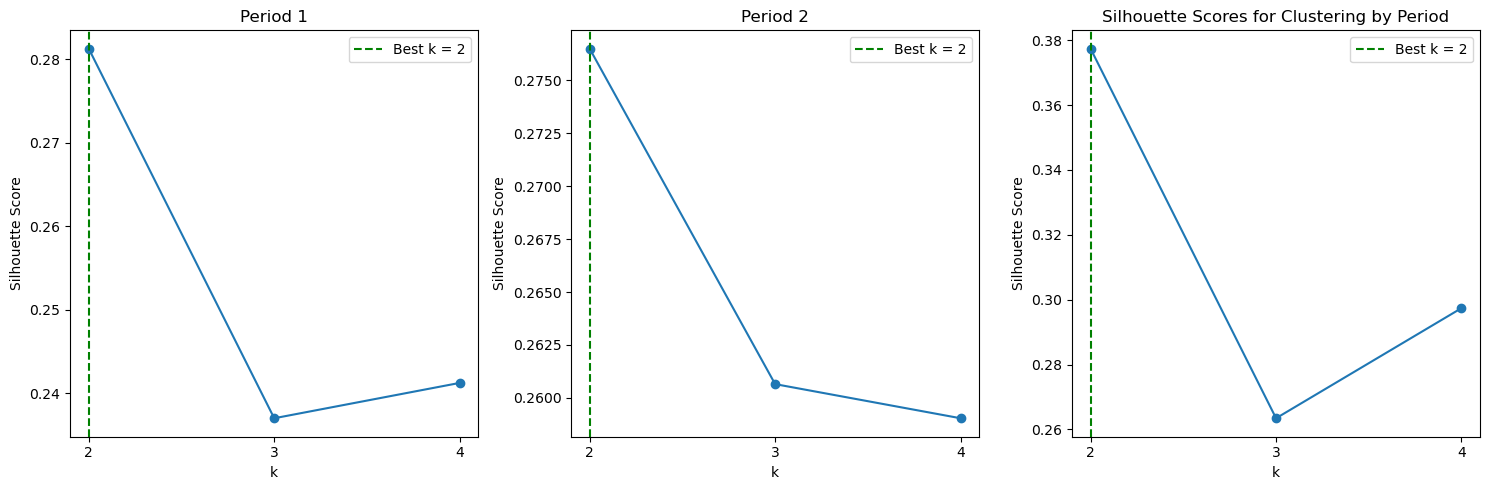

In [11]:
def plot_silhouette_scores_per_period(students_by_period, k_range=(2, 10)):
    periods = list(students_by_period.keys())
    fig, axes = plt.subplots(1, len(periods), figsize=(5 * len(periods), 5), squeeze=False)

    for col_idx, period_name in enumerate(periods):
        df_clean = students_by_period[period_name].dropna(subset=columns_used)
        X_scaled = StandardScaler().fit_transform(df_clean[columns_used].values)

        silhouette_scores = []
        k_values = list(range(k_range[0], k_range[1] + 1))

        for k in k_values:
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            silhouette_scores.append(score)

        best_k = k_values[np.argmax(silhouette_scores)]

        ax = axes[0, col_idx]
        ax.plot(k_values, silhouette_scores, marker='o')
        ax.axvline(best_k, color='green', linestyle='--', label=f'Best k = {best_k}')
        ax.set_title(f"{period_name}")
        ax.set_xlabel('k')
        ax.set_ylabel('Silhouette Score')
        ax.set_xticks(k_values)
        ax.legend()

    plt.title('Silhouette Scores for Clustering by Period')
    plt.tight_layout()
    plt.show()

# Plot silhouette scores
plot_silhouette_scores_per_period(students_by_period, k_range=(2, 4))

**Observation:**

According to the silhouette score, the optimal number of clusters is 2, unlike in M4 where we identified 4 clusters (which could potentially be reduced to 3). This difference may be explained by several factors:

- The 4 cluster structure in M4 was based on the full dataset treated as a single partition. Here, the data is split across three distinct time periods, which can significantly influence how clusters are formed.
- In this analysis, we use the silhouette score, whereas M4 relied on the elbow method. We chose a different approach because the elbow method did not provide consistent results in M4.

As a result, we will cluster students into two groups and calculate the average score for each cluster.

In [17]:
kmeans_model = KMeans(n_clusters=2, random_state=42, n_init=10)
color_1 = 'green'
color_2 = 'red'
profile_labels = ['Profile 1 (higher score)', 'Profile 2 (lower score)']
profile_colors = {0: color_1, 1: color_2}
profile_legend = [
    mpatches.Patch(color=color_1, label=profile_labels[0]),
    mpatches.Patch(color=color_2, label=profile_labels[1])
]

In [13]:
def compute_average_features_with_score(students_by_period):
    rows = []

    for period, df in students_by_period.items():
        df_clean = df.dropna(subset=columns_used + ['median_score']).copy()
        X_scaled = StandardScaler().fit_transform(df_clean[columns_used])

        df_clean['cluster'] = kmeans_model.fit_predict(X_scaled)

        medians = df_clean.groupby('cluster')['median_score'].median()
        sorted_clusters = medians.sort_values(ascending=False).index.tolist()
        cluster_map = {orig: i for i, orig in enumerate(sorted_clusters)}
        df_clean['cluster_mapped'] = df_clean['cluster'].map(cluster_map)

        group = df_clean.groupby('cluster_mapped')[columns_used].mean()
        group['median_score'] = df_clean.groupby('cluster_mapped')['median_score'].median()
        group.index = profile_labels
        group.index = pd.MultiIndex.from_product([[period], profile_labels], names=["Period", "Profile"])

        rows.append(group)

    results = pd.concat(rows).round(2)
    return results

# Compute average features with score
average_features_with_score = compute_average_features_with_score(students_by_period)
print("\nAverage features with score:")
display(average_features_with_score)


Average features with score:


median_gap_days  active_days_count  \
Period   Profile                                                        
Period 1 Profile 1 (higher score)             3.24               8.68   
         Profile 2 (lower score)              5.11               6.21   
Period 2 Profile 1 (higher score)             8.69               5.09   
         Profile 2 (lower score)              4.30              10.01   
Period 3 Profile 1 (higher score)             8.98               4.34   
         Profile 2 (lower score)              3.21               9.48   

                                   activities_count  activity_types_count  \
Period   Profile                                                            
Period 1 Profile 1 (higher score)             32.70                  2.80   
         Profile 2 (lower score)              14.41                  2.04   
Period 2 Profile 1 (higher score)             13.47                  1.98   
         Profile 2 (lower score)              47.86                  2.62   
Period 3 Profile 1 (higher score)             11.99                  1.87   
         Profile 2 (lower score)              51.90                  2.69   

                                   median_activity_duration_minutes  \
Period   Profile                                                      
Period 1 Profile 1 (higher score)                              6.78   
         Profile 2 (lower score)                               9.89   
Period 2 Profile 1 (higher score)                             10.01   
         Profile 2 (lower score)                               4.04   
Period 3 Profile 1 (higher score)                              9.45   
         Profile 2 (lower score)                               3.89   

                                   median_score  
Period   Profile                                 
Period 1 Profile 1 (higher score)         56.25  
         Profile 2 (lower score)          44.44  
Period 2 Profile 1 (higher score)         64.71  
         Profile 2 (lower score)          57.47  
Period 3 Profile 1 (higher score)         58.82  
         Profile 2 (lower score)          58.57

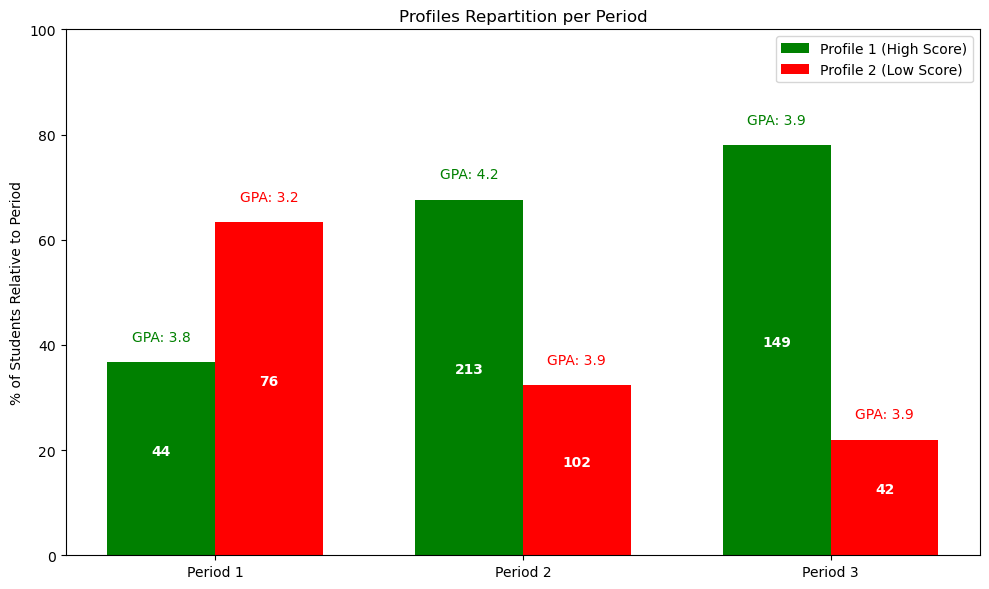

In [49]:
def scale_gpa(values, swiss_scale):
    if swiss_scale:
        return (values / 100) * 5 + 1
    return values

def plot_cluster_distribution(students_by_period, swiss_scale=False):
    periods, percents, medians, counts = [], [], [], []

    for period_name, df in students_by_period.items():
        df_clean = df.dropna(subset=columns_used + ['median_score']).copy()
        X_scaled = StandardScaler().fit_transform(df_clean[columns_used])

        # KMeans and map: 0 = high-score
        kmeans_model = KMeans(n_clusters=2, random_state=42, n_init=10)
        df_clean['cluster'] = kmeans_model.fit_predict(X_scaled)

        cluster_medians = df_clean.groupby('cluster')['median_score'].median()
        sorted_clusters = cluster_medians.sort_values(ascending=False).index.tolist()
        cluster_map = {orig: i for i, orig in enumerate(sorted_clusters)}
        df_clean['cluster_mapped'] = df_clean['cluster'].map(cluster_map)

        stats = df_clean.groupby('cluster_mapped')['median_score'].agg(['median', 'count']).reset_index()
        stats['percent'] = stats['count'] / len(df_clean) * 100
        stats['median'] = scale_gpa(stats['median'], swiss_scale)

        stats = stats.sort_values(by='cluster_mapped').reset_index(drop=True)

        periods.extend([period_name] * 2)
        percents.extend(stats['percent'].tolist())
        medians.extend(stats['median'].tolist())
        counts.extend(stats['count'].tolist())

    x_labels = sorted(students_by_period.keys())
    x = np.arange(len(x_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    high_idx = x
    low_idx = x + width

    high_percents = percents[::2]
    low_percents = percents[1::2]
    high_medians = medians[::2]
    low_medians = medians[1::2]
    high_counts = counts[::2]
    low_counts = counts[1::2]

    bar1 = ax.bar(high_idx, high_percents, width, label='Profile 1 (High Score)', color=color_1)
    bar2 = ax.bar(low_idx, low_percents, width, label='Profile 2 (Low Score)', color=color_2)

    for i in range(len(x_labels)):
        ax.text(high_idx[i], high_percents[i] + 1, f"GPA: {high_medians[i]:.1f}\n", ha='center', color=color_1)
        ax.text(low_idx[i], low_percents[i] + 1, f"GPA: {low_medians[i]:.1f}\n", ha='center', color=color_2)
        ax.text(high_idx[i], high_percents[i] / 2, f"{high_counts[i]}\n", ha='center', va='center', color='white', fontweight='bold')
        ax.text(low_idx[i], low_percents[i] / 2, f"{low_counts[i]}\n", ha='center', va='center', color='white', fontweight='bold')

    ax.set_ylabel('% of Students Relative to Period')
    ax.set_title('Profiles Repartition per Period')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 100)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot cluster distribution
plot_cluster_distribution(students_by_period, swiss_scale=True)

**Observation:**

We observe that in the first and second periods, there is a significant gap in grades between the top-performing and lower-performing student profiles: specifically, differences of 12 (56-44) and 7 (64-57) points respectively, across clusters of several hundred students. However, in Period 3, the two profiles show very similar scores (58). Across all periods, median scores fall within the same range of \[55, 65].

As for the distribution of students across clusters, there appear to be significantly fewer high-performing students in the first period, with their numbers increasing notably in the subsequent periods. This may suggest that student performance improved over time, possibly due to increased engagement or adaptation to the learning environment.

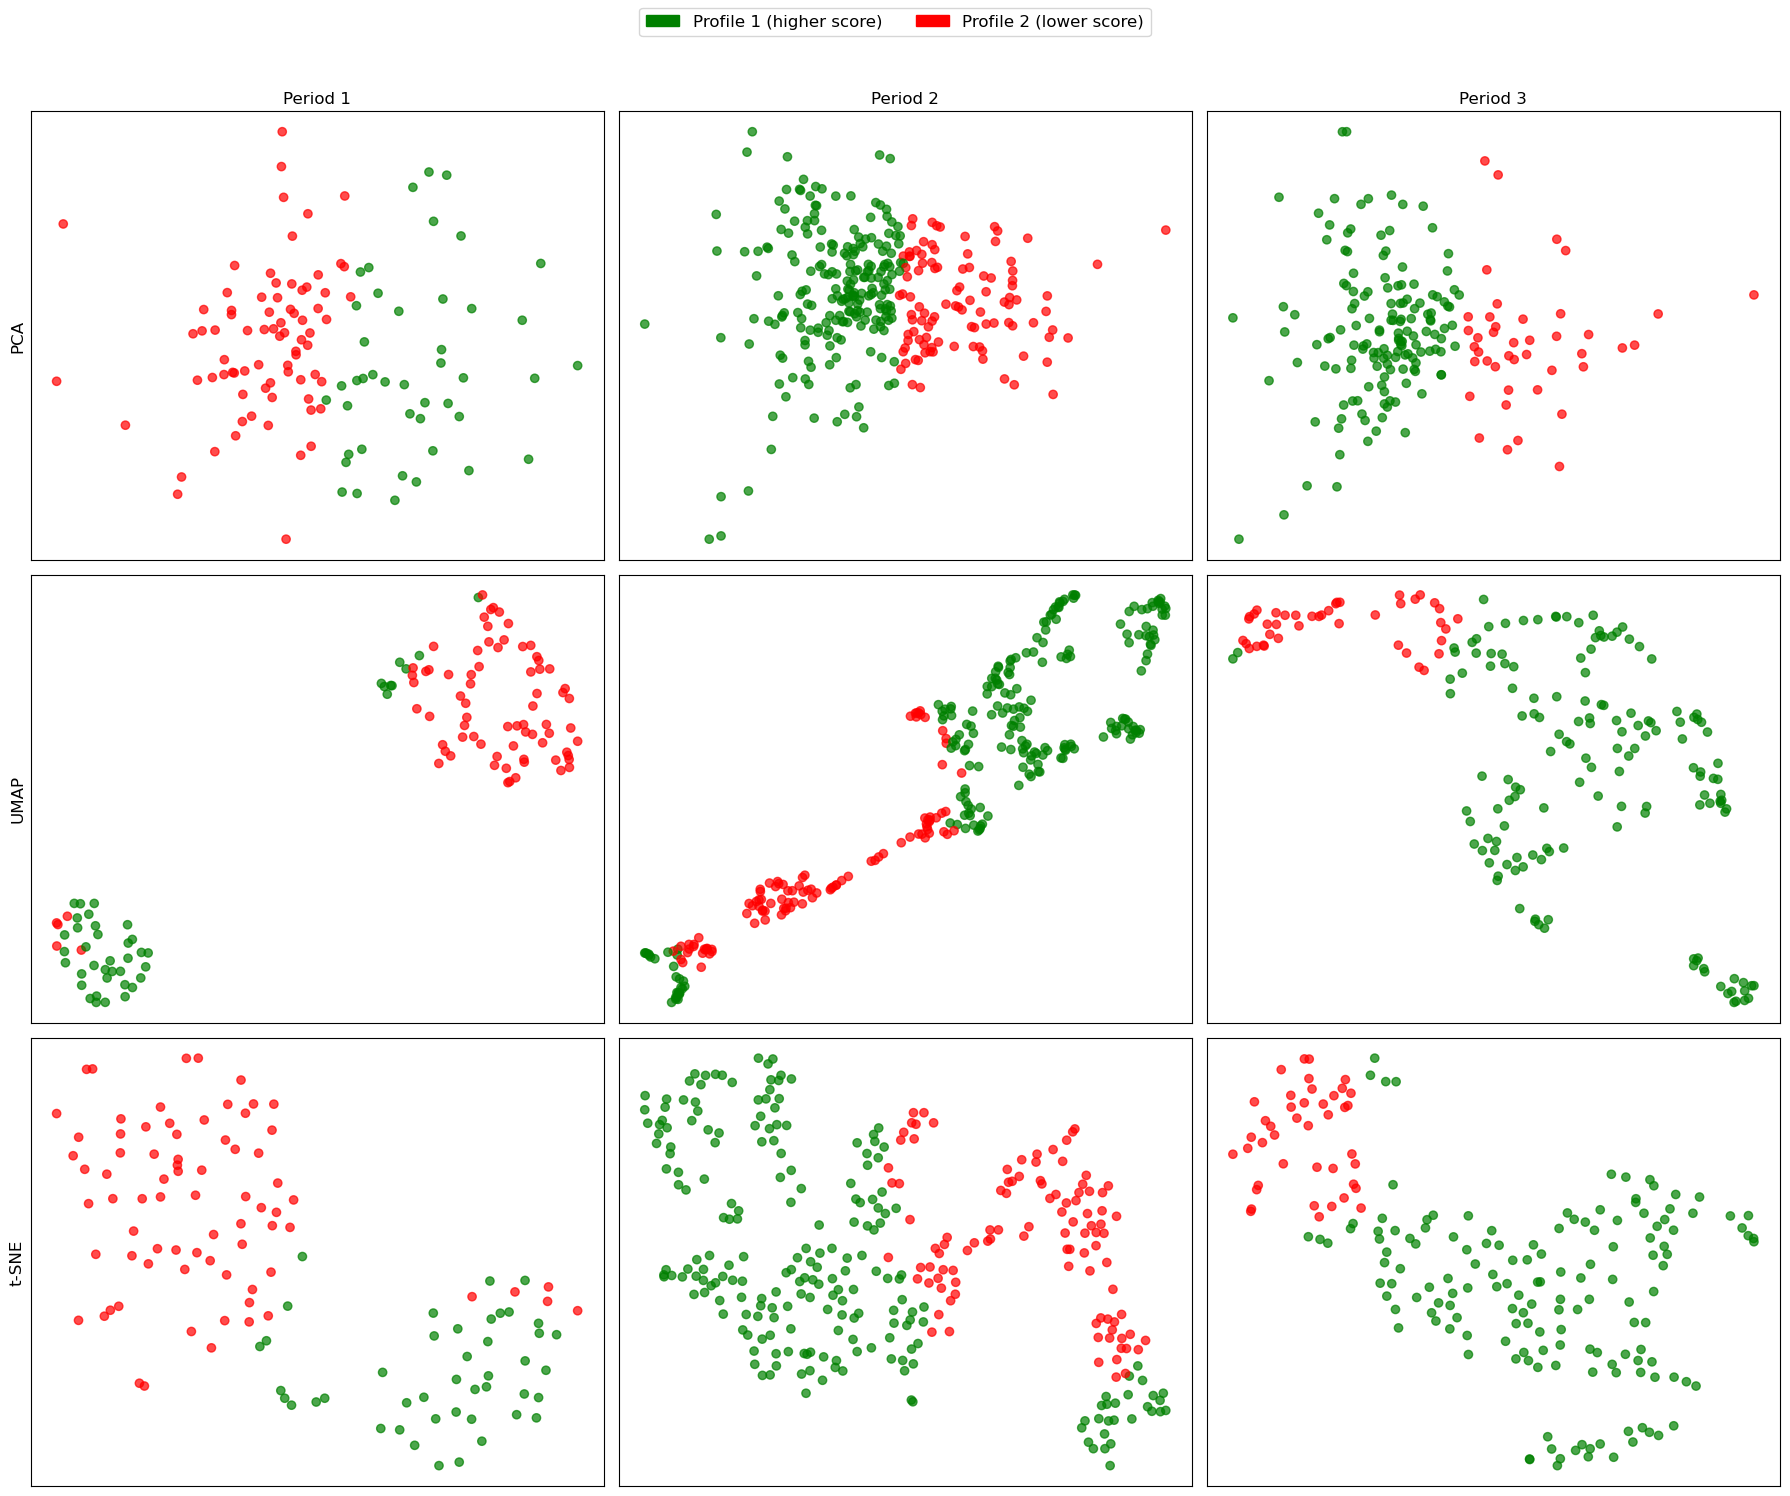

In [18]:
def plot_dimensionality_reductions(students_by_period):
    reduction_methods = ['PCA', 'UMAP', 't-SNE']
    periods = sorted(students_by_period.keys())
    fig, axes = plt.subplots(len(reduction_methods), len(periods), figsize=(6 * len(periods), 5 * len(reduction_methods)), squeeze=False)

    for col_idx, period in enumerate(periods):
        df = students_by_period[period].dropna(subset=columns_used + ['median_score']).copy()
        X_scaled = StandardScaler().fit_transform(df[columns_used])

        df['cluster'] = kmeans_model.fit_predict(X_scaled)
        cluster_medians = df.groupby('cluster')['median_score'].median()
        sorted_clusters = cluster_medians.sort_values(ascending=False).index.tolist()
        cluster_map = {orig: i for i, orig in enumerate(sorted_clusters)}
        df['cluster_mapped'] = df['cluster'].map(cluster_map)
        y = df['cluster_mapped'].values

        reductions = [
            PCA(n_components=2).fit_transform(X_scaled),
            umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled),
            TSNE(n_components=2, init='pca', random_state=42).fit_transform(X_scaled)
        ]

        for row_idx, X_red in enumerate(reductions):
            ax = axes[row_idx, col_idx]
            colors = [profile_colors[c] for c in y]
            ax.scatter(X_red[:, 0], X_red[:, 1], c=colors, alpha=0.7)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(True)

            if col_idx == 0:
                ax.set_ylabel(reduction_methods[row_idx], fontsize=12)
            if row_idx == 0:
                ax.set_title(period, fontsize=12)

    fig.legend(handles=profile_legend, loc='upper center', ncol=2, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot dimensionality reductions
plot_dimensionality_reductions(students_by_period)

**Observation:**

The projection above shows the 2D clustering using three methods: PCA, UMAP, and t-SNE. 
- PCA consistently reveals two distinct clusters across all periods, suggesting that the data may be linearly separable. 
- UMAP captures them particularly well in Period 1, with two clearly separated groups in different colors.

### B) Student Evolution Across Clusters Over Time Periods

In [16]:
def plot_cluster_transition_sankey(students_by_period):
    sorted_periods = sorted(students_by_period.keys())
    records = []

    for period in sorted_periods:
        df = students_by_period[period].dropna(subset=columns_used + ['median_score']).copy()
        X_scaled = StandardScaler().fit_transform(df[columns_used])
        df['cluster'] = kmeans_model.fit_predict(X_scaled)

        medians = df.groupby('cluster')['median_score'].median()
        sorted_clusters = medians.sort_values(ascending=False).index.tolist()
        cluster_map = {orig: i for i, orig in enumerate(sorted_clusters)}
        df['cluster_mapped'] = df['cluster'].map(cluster_map)

        for _, row in df[['user_id', 'cluster_mapped']].iterrows():
            records.append((row['user_id'], period, int(row['cluster_mapped'])))

    transition_df = pd.DataFrame(records, columns=['user_id', 'period', 'cluster'])
    pivot = transition_df.pivot(index='user_id', columns='period', values='cluster')

    label_index, label_list, node_colors, period_cluster_nodes = {}, [], [], []

    for period in sorted_periods:
        for cluster in [0, 1]:
            node_id = f"{period}_C{cluster}"
            label_index[node_id] = len(label_list)
            label_list.append(profile_labels[cluster])
            period_cluster_nodes.append((period, cluster))
            node_colors.append(profile_colors[cluster])

    source, target, value = [], [], []
    for i in range(len(sorted_periods) - 1):
        p1, p2 = sorted_periods[i], sorted_periods[i + 1]
        transitions = pivot[[p1, p2]].dropna().astype(int)
        for (c1, c2), count in transitions.groupby([p1, p2]).size().items():
            label1 = f"{p1}_C{c1}"
            label2 = f"{p2}_C{c2}"
            source.append(label_index[label1])
            target.append(label_index[label2])
            value.append(count)

    link_labels = [f"{cnt} students went from {label_list[s]} to {label_list[t]}" for s, t, cnt in zip(source, target, value)]
    node_counts = [0] * len(label_list)
    for s, t, v in zip(source, target, value):
        node_counts[s] += v
        node_counts[t] += v
    node_hover = [f"{count} students are in {label}" for count, label in zip(node_counts, label_list)]

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="rgba(0,0,0,0)", width=0),
            label=label_list,
            color=node_colors,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=node_hover
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            hovertemplate='%{customdata}<extra></extra>',
            customdata=link_labels
        )
    )])

    annotations = []
    for i, period in enumerate(sorted_periods):
        annotations.append(dict(
            x=i / (len(sorted_periods) - 1),
            y=-0.1,
            text=period,
            showarrow=False,
            xanchor='center',
            yanchor='top',
            font=dict(size=10)
        ))

    fig.update_layout(
        title_text="Student Profile Transitions Over Time",
        title_x=0.5,
        font_size=10,
        margin=dict(l=40, r=40, t=60, b=70),
        annotations=annotations
    )

    fig.show()

# Plot cluster transition Sankey diagram
plot_cluster_transition_sankey(students_by_period)

**Observation:**

This Sankey diagram illustrates how students transition between clusters across consecutive time periods. We observe the following patterns in both transitions:

* A large majority of low-performing students move to the high-performing cluster in the next period: 
    - 52/62 (83%) from Period 1 to Period 2
    - 39/57 (68%) from Period 2 to Period 3.
* Conversely, only a minority of students transition from the high-performing to the low-performing cluster: 
    - 14/32 from Period 1 to Period 2
    - 6/86 from Period 2 to Period 3.

**Conclusion:**

This suggests an overall improvement in student performance over time, with many initially low-performing students progressing to stronger profiles, and high-performing students maintaining their level.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?